# Intro to CatBoost

CatBoost is a gradient boosting library that turns simple decision trees into a robust ensemble model for classification and regression. It is also popular for natively handling categorical encoding.

However... what does any of this mean in 'human' language?

Let's start from the rudimentary element: decision trees.

A decision tree is a simple flowchart for making decisions - just like the ones we often contemplate in our daily lives. While searching for a new phone online, we may look for phones below 50,000 taka. Which means if there are any above 50, we don't bother checking its features. For the ones under 50k, we look for 32MP or above camera. If it's below 32MP, we avoid. Turn this into a simple yes/no flowchart and voila, it's a fancy decision tree.

There are models such as Decision Tree Classifiers, using a single tree to develop a predictive algorithm. It works, but it's prone to overfitting (memorizing patterns instead of generalizing) given there's only one tree.

This is where CatBoost comes in. CatBoost is built on a Gradient Boosting Machine (GBM), which iteratively constructs shallow trees to correct prediction errors or residuals from prior trees. It means, GBMs optimize for loss functions like log-loss or RMSE. Again, human language: If I'm predicting sales, GBM will not focus on making a massive decision tree to predict the outcome. Instead, it will make a short tree, check its errors/residuals and try to figure out what went wrong. It's like not going out with umbrella because weather forecast shows 'no rain', only to go out and realize you need umbrellas for sunny days too. Then the insight is incorporated into the next tree. You keep going, until the errors are tiny.

There are other popular gradient boosting libraries, too. XGBoost, or eXtreme Gradient Boosting constructs trees parallely, uses histogram-based split analysis and conducts L2 regularization - all to gain incredibly fast results with large datasets. LightGBM uses leaf-wise tree growth and histogram binning. Why use CatBoost, then?

There are a few key reasons/use cases:
1. Let's circle back to when I mentioned 'natively handling categorical encoding'. In other GBM (or almost any standard) models, categorical values need to be encoded to separate numeric values, and often, one-hot encoding is needed. It means instead of having one column (feature) for 50 products with Kitkat as the item, there will be 49 separate binarized columns, with the Kitkat column as 1 (or if all the columns are 0 and none are labelled Kitkat, it's technically Kitkat). It is extremely memory-intensive, often misleads feature importance analysis and makes the dataset more complex. CatBoost takes care of it all, on its own. All we have to do is specify the categorical features while fitting the model.
2. CatBoost trees are symmetric; meaning, the splits are same per level. It's easier on CPU/GPU while handling massive data load.
3. CatBoost uses 'ordered boosting'. Instead of using the entire dataset at once to compute errors (like most boosting algorithms), CatBoost shuffles the data randomly and, for each data point, calculates errors using only prior points in that shuffle. This mimics how the model will predict on new, unseen data, just like in real-life application.

Yandex, the Russian company that developed CatBoost, actually developed it to optimize a search engine algorithm. They made CatBoost so convenient that the data community recognized its many uses, starting from churn rates to default risk prediction to just about any dataset with many values under a categorical feature (e.g. product IDs or countries).

**In this notebook, we will train CatBoost with a Credit Card default dataset consisting around 30,000 instances and 23 features. Afterwards, we will also test with other datasets native to scikit-learn. The objective is to demonstrate the inner workings of CatBoost.**

# Initialization

In [86]:
import pandas as pd
import numpy as np

In [87]:
pip install ucimlrepo

In [88]:
!pip install catboost

In [89]:
# copy-pasted the import code from UCI ML Repository

from ucimlrepo import fetch_ucirepo

# fetch dataset

default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets


# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

"""Feature details
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment.
We tracked the past monthly payment records (from April to September, 2005) as follows:
X6 = the repayment status in September, 2005;
X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005.
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005."""

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

'Feature details\nX1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.\nX2: Gender (1 = male; 2 = female).\nX3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).\nX4: Marital status (1 = married; 2 = single; 3 = others).\nX5: Age (year).\nX6 - X11: History of past payment.\nWe tracked the past monthly payment records (from April to September, 2005) as follows:\nX6 = the repayment status in September, 2005;\nX7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005.\nThe measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.\nX12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amoun

# Training a Credit Card Default Prediction dataset with CatBoost

In [90]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import shap

In [91]:
cat_features = ['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # Train-test split at a 4:1 ratio.

model = CatBoostClassifier(iterations=3000, learning_rate=0.08, depth=6, eval_metric='AUC', early_stopping_rounds=100, verbose=False)

''' This is what the hyperparameters mean:
iterations: Number of trees to build in the model.
learning_rate: How much each tree adjusts predictions (smaller = slower, more accurate).
depth: Maximum depth of each tree (controls complexity).
eval_metric: Metric to evaluate model performance (e.g., AUC, Accuracy).
early_stopping_rounds: Stops training if validation performance doesn’t improve for this many rounds.
'''

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)


model.fit(train_pool)

''' cat_features is the list of categorical features to encode natively.
This is one of the greatest utilities of CatBoost - it saves us from the trouble of manually encoding categorical features.'''

' cat_features is the list of categorical features to encode natively.\nThis is one of the greatest utilities of CatBoost - it saves us from the trouble of manually encoding categorical features.'

CatBoost, like other algorithms such as Random Forest, has feature importance scoring system. It shows how important certain features are to the model predictions. Features with low importance may contribute to noise, often requiring some extra back-testing to improve performance.

In [93]:
# renaming all the columns for more clarity

X = X.rename(columns={
    'X1': 'credit_amt',
    'X2': 'gender',
    'X3': 'edu',
    'X4': 'marital_status',
    'X5': 'age',
    'X6': 'repayment_sept',
    'X7': 'repayment_aug',
    'X8': 'repayment_july',
    'X9': 'repayment_june',
    'X10': 'repayment_may',
    'X11': 'repayment_april',
    'X12': 'bill_statement_amt_sept',
    'X13': 'bill_statement_amt_aug',
    'X14': 'bill_statement_amt_july',
    'X15': 'bill_statement_amt_june',
    'X16': 'bill_statement_amt_may',
    'X17': 'bill_statement_amt_april',
    'X18': 'pmt_sept',
    'X19': 'pmt_aug',
    'X20': 'pmt_july',
    'X21': 'pmt_june',
    'X22': 'pmt_may',
    'X23': 'pmt_april'
})

X.sample()

,credit_amt,gender,edu,marital_status,age,repayment_sept,repayment_aug,repayment_july,repayment_june,repayment_may,...,bill_statement_amt_july,bill_statement_amt_june,bill_statement_amt_may,bill_statement_amt_april,pmt_sept,pmt_aug,pmt_july,pmt_june,pmt_may,pmt_april
12429,150000,1,2,2,42,-2,-2,-2,-2,-2,...,-3,-3,-3,1040,0,0,0,0,1043,0


In the next bit of code, we test the accuracy and the level of fit. For that, we need predicted values of y for both test and train data. To measure fit, we use ROC AUC score.

In [94]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
roc_train = roc_auc_score(y_train, y_train_pred)
roc_test = roc_auc_score(y_test, y_pred)

In [95]:
roc_train

np.float64(0.8359693167626105)

In [96]:
roc_test

np.float64(0.6539385323213354)

In [35]:
accuracy_score(y_test, y_pred)

0.8156666666666667

**Evaluation: The ROC-AUC score for train data is more than the test data, which indicates overfitting. Meaning, the model sort of 'memorized' the patterns during training, but failed to generalize them with same accuracy for the test data.**

*Issues of overfitting can be handled by tuning the hyperparameters. For example, if the number of iterations are reduced, the model will capture less complexity/noise. This is the model's version of 'overthinking' - the more trees you create, the more complex patterns it will capture, even though the patterns cannot be generalized. Tree depth can be decreased for the same reason, alongside changing the learning rate.*

In [97]:
model_v2 = CatBoostClassifier(iterations=1500, learning_rate=0.1, depth=4, eval_metric='AUC', early_stopping_rounds=100, verbose=False)

model_v2.fit(train_pool)

In [98]:
y_pred = model_v2.predict(X_test)
y_train_pred = model_v2.predict(X_train)
roc_train_v2 = roc_auc_score(y_train, y_train_pred)
roc_test_v2 = roc_auc_score(y_test, y_pred)

In [99]:
roc_train_v2

np.float64(0.704857036934611)

In [100]:
roc_test_v2

np.float64(0.6603379150998752)

In [101]:
accuracy_score(y_test, y_pred)

0.8226666666666667

**Evaluation: In this case, the training ROC-AUC score has reduced a lot and the test ROC has improved, although by 1%. Same goes for the accuracy score. The disparity between training and test AUC has been reduced.**

*Many other hyper-parametric tuning can be done to deal with overfitting/underfitting situations. They include:*

1.   l2_leaf_reg: L2 Regularization to prevent overfitting by penalizing large weights (i.e. possibly overconfident generalizations).
2. bagging_temperature: Controls how much data is randomly sampled for each tree.
3. max_leaves: Maximum number of leaf nodes in a tree (limits/enhances complexity).



**Now let's check feature importance using built-in method and SHAP:**

In [102]:
feature_name_map = {
    'X1': 'credit_amt',
    'X2': 'gender',
    'X3': 'edu',
    'X4': 'marital_status',
    'X5': 'age',
    'X6': 'repayment_sept',
    'X7': 'repayment_aug',
    'X8': 'repayment_july',
    'X9': 'repayment_june',
    'X10': 'repayment_may',
    'X11': 'repayment_april',
    'X12': 'bill_statement_amt_sept',
    'X13': 'bill_statement_amt_aug',
    'X14': 'bill_statement_amt_july',
    'X15': 'bill_statement_amt_june',
    'X16': 'bill_statement_amt_may',
    'X17': 'bill_statement_amt_april',
    'X18': 'pmt_sept',
    'X19': 'pmt_aug',
    'X20': 'pmt_july',
    'X21': 'pmt_june',
    'X22': 'pmt_may',
    'X23': 'pmt_april'
}

In [103]:
feature_importance_builtin = model_v2.get_feature_importance(prettified=True) #feature importance evaluation using built-in method
feature_importance_builtin['feature_name'] = feature_importance_builtin['Feature Id'].map(feature_name_map)
feature_importance_builtin.sort_values(by='Importances', ascending=False)

,Feature Id,Importances,feature_name
0,X6,12.560691,repayment_sept
1,X12,7.615774,bill_statement_amt_sept
2,X1,7.388630,credit_amt
3,X20,6.412510,pmt_july
4,X21,5.963758,pmt_june
5,X19,5.452121,pmt_aug
6,X23,5.443107,pmt_april
7,X18,5.061807,pmt_sept
8,X5,4.868360,age
9,X14,4.784567,bill_statement_amt_july


^CatBoost has a native method to check feature importance, and it tells us how much a feature reduces impurity or improves overall accuracy. Meaning, the most obvious differentiating factors (e.g. people with income below $1000/yr not buying an iPhone 15) show more weight.

However... it doesn't show how/why a feature mattered for a prediction, and how each sample was impacted.

SHAP does that pretty well. Follow the next code.

In [104]:
shap_values = model_v2.get_feature_importance(test_pool, type='ShapValues')

feature_names = model_v2.feature_names_

all_columns = feature_names + ["base_value"]

shap_df = pd.DataFrame(shap_values, columns=all_columns)

shap_df = shap_df.rename(columns={
    'X1': 'credit_amt',
    'X2': 'gender',
    'X3': 'edu',
    'X4': 'marital_status',
    'X5': 'age',
    'X6': 'repayment_sept',
    'X7': 'repayment_aug',
    'X8': 'repayment_july',
    'X9': 'repayment_june',
    'X10': 'repayment_may',
    'X11': 'repayment_april',
    'X12': 'bill_statement_amt_sept',
    'X13': 'bill_statement_amt_aug',
    'X14': 'bill_statement_amt_july',
    'X15': 'bill_statement_amt_june',
    'X16': 'bill_statement_amt_may',
    'X17': 'bill_statement_amt_april',
    'X18': 'pmt_sept',
    'X19': 'pmt_aug',
    'X20': 'pmt_july',
    'X21': 'pmt_june',
    'X22': 'pmt_may',
    'X23': 'pmt_april'
})

print(shap_df.head())

   credit_amt    gender       edu  marital_status       age  repayment_sept  \
0    0.478769  0.050633  0.055286       -0.073283  0.040220       -0.277659   
1   -0.066204 -0.049887 -0.081964       -0.071980 -0.082602       -0.312334   
2    0.372427 -0.062716  0.030806        0.091569 -0.021867       -0.284329   
3    0.048423  0.054214  0.027541       -0.050873  0.106430       -0.298025   
4    0.275861 -0.031033  0.062300       -0.052971  0.041617       -0.283401   

   repayment_aug  repayment_july  repayment_june  repayment_may  ...  \
0      -0.088321       -0.031918       -0.032157      -0.007749  ...   
1      -0.100992       -0.050552       -0.041912      -0.023160  ...   
2      -0.084958       -0.038749       -0.044776      -0.030272  ...   
3      -0.110661       -0.045159       -0.036272      -0.019533  ...   
4      -0.092917       -0.034982       -0.070572      -0.015032  ...   

   bill_statement_amt_june  bill_statement_amt_may  bill_statement_amt_april  \
0           

^^ Each row in this SHAP dataframe is a single prediction.

Each cell in the row is a signed number. The contribution of that feature to the difference between the model’s base value (average prediction) and this specific prediction.

For example, in the sample indexed 0, value for credit_amt is 0.48 (appx). The base value is -1.60, which is the model's expected prediction if it knew nothing. X1 = 0.48 implies that the amount of given credit in the sample pushed the prediction up by 0.48. Similarly, the value of gender pushed the prediction up by 0.05.

Meaning, if we use SHAP, we get a breakdown of why a specific prediction was made. Traditional feature importance only says feature x is most important. However, SHAP points out exactly how a feature mattered for a certain prediction.

In [107]:
importance = shap_df.abs().mean().sort_values(ascending=False)
importance

,0
base_value,1.606885
repayment_sept,0.402932
credit_amt,0.244080
bill_statement_amt_sept,0.182866
pmt_sept,0.131185
pmt_aug,0.123448
bill_statement_amt_july,0.113209
repayment_aug,0.105044
pmt_june,0.103532
pmt_july,0.100503


^^ We can also find the mean absolute SHAP values to check the overall feature importance. Note that the ranking is quite similar to the built-in feature importance analysis, but the weightage is quite different. In both cases, X6 (repayment status in the most recent month) was the most influential predictor.

**An alternative approach to train-test - Cross-Validation**

Cross-Validation (CV) is a technique used to assess how well Machine learning models perform on unseen data. Specifically, there are techniques such as k-fold validation, which evaluate a machine learning model’s performance by dividing the dataset into multiple subsets, or "folds," and testing the model on each one while training on the others. For example, in this 30,000-sample dataset, 5-fold CV was applied, splitting the data into 5 parts (~6,000 samples per test fold, ~24,000 per training fold). Each fold serves as a test set once, with the model trained on the remaining four, and the performance metric (AUC) is averaged across all folds.

CV can provide a more reliable estimate of a model’s performance compared to a single train-test split, especially for real-world applications like predicting default. A single split depends on one random division, which might not represent the full dataset, especially with 30,000 samples where imbalances or variability (e.g., rare default cases) can skew results. CV uses all data for testing across folds, reducing the risk of a "lucky" or "bad" split. It also measures stability via the standard deviation of metrics, ensuring predictions are consistent.

CatBoost supports CV natively, as shown below.

In [60]:
X, y = make_classification(n_samples=30000, n_features=20, n_classes=2, random_state=42)

pool = Pool(X, label=y)

# Specifying model parameters

params = {
    'loss_function': 'Logloss',
    'iterations': 3000,
    'learning_rate': 0.08,
    'depth': 6,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 100,
    'verbose': 100,
    'random_seed': 42
}

# 5-fold cross-validation
cv_results = cv(
    pool=pool,
    params=params,
    fold_count=5,  # 5 folds
    stratified=True,
    shuffle=True,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	test: 0.9321451	best: 0.9321451 (0)	total: 18.2ms	remaining: 54.4s
100:	test: 0.9678466	best: 0.9679067 (93)	total: 2.7s	remaining: 1m 17s
200:	test: 0.9685195	best: 0.9686330 (171)	total: 4.2s	remaining: 58.6s
300:	test: 0.9683858	best: 0.9686454 (223)	total: 5.65s	remaining: 50.6s

bestTest = 0.9686454446
bestIteration = 223

Training on fold [1/5]
0:	test: 0.9309120	best: 0.9309120 (0)	total: 14.4ms	remaining: 43s
100:	test: 0.9709054	best: 0.9709392 (97)	total: 1.49s	remaining: 42.6s
200:	test: 0.9712517	best: 0.9713294 (178)	total: 2.96s	remaining: 41.2s

bestTest = 0.9713294413
bestIteration = 178

Training on fold [2/5]
0:	test: 0.9304653	best: 0.9304653 (0)	total: 14.5ms	remaining: 43.4s
100:	test: 0.9671332	best: 0.9672191 (97)	total: 1.53s	remaining: 43.8s
200:	test: 0.9675219	best: 0.9675764 (196)	total: 3.58s	remaining: 49.8s
300:	test: 0.9678417	best: 0.9678986 (243)	total: 5.89s	remaining: 52.8s

bestTest = 0.967898552
bestIteration = 243

Traini

In [61]:
cv_results.tail(1)

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
343,343,0.96984,0.002154,0.222109,0.00804,0.172037,0.010251


**Result interpretation**

Note that the hyperparameters are similar to that of our first model which had overfit. But in this case, the test-AUC mean is an impressive 96% with minimal standard deviation. For the first train-test based model, it was 65%. This could stem from the test set (6,000 samples) missing key patterns or imbalances not captured in the single split. CV’s strength lies in testing across five diverse subsets, ensuring all 30,000 samples are evaluated, which likely balanced out quirks (e.g., imbalanced classes) that skewed the single test set.



# Checking out more CatBoost features

*In our previous model, we witnessed how CatBoost can natively handle categorical encoding. All it takes is one simple argument to specify the categorical features. However, CatBoost is unique through its many other characteristics.*

**Tree effect in CatBoost:**

In [ ]:
# In this block, we will compare the decision trees of Decision Tree Classifier and CatBoost using the Iris dataset native to scikit-learn.

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

catboost = CatBoostClassifier(iterations=5, depth=3, verbose=0, random_seed=42)
catboost.fit(X_train, y_train)

dt_dot_data = export_graphviz(dt, out_file=None, feature_names=data.feature_names,
                              class_names=data.target_names, filled=True, rounded=True)
dt_graph = graphviz.Source(dt_dot_data)
dt_graph.render('decision_tree_0', format='png', cleanup=True)  # Saves as PNG; check the files

catboost_graph = catboost.plot_tree(tree_idx=0, pool=None)
catboost_graph.render('catboost_tree_0', format='png', cleanup=True)  # Saves as PNG; check the files

'catboost_tree_0.png'

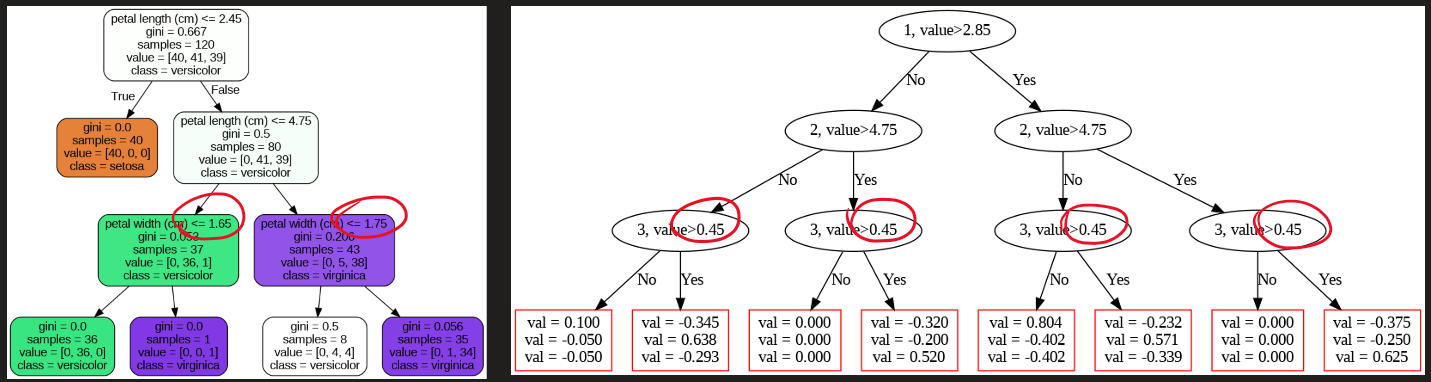

Explanation:
On the left, we have the decision tree for DT Classifier. On the right, we have decision tree for CatBoost.

Notice how (check red circles) the split values are different in DT, but the same in CatBoost. It's because CatBoost splits class by minimizing prediction loss, whereas DT uses gini/entropy. The gini coefficient is unique for each situation. This fundamental difference makes CatBoost:
1. Faster (takes less memory space due to less unique values)
2. Robust to overfitting; if DT keeps going on using gini, there may be splits for instances which cannot be generalized (e.g. calling an apple red instead of green because of a pigment that isn't actually found in 99% of red apples)
3. (On the flip side) Not the best for complex datasets where capturing minute differences is crucial; CatBoost may oversimplify in those cases.

**Learning rate: What does it imply and why is it important?**

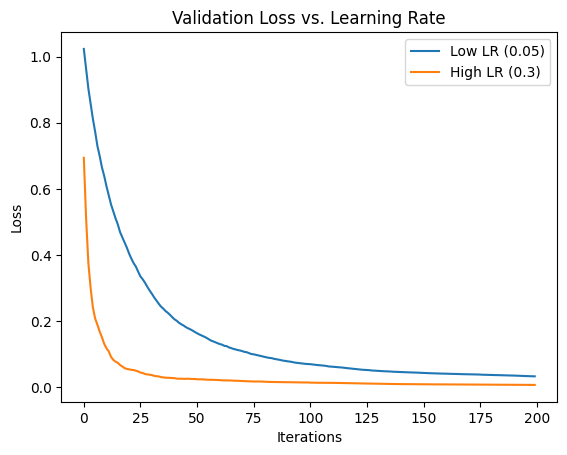

In [ ]:
# To visualize the effect of learning rate - a plot is being graphed for two different learning rates

import matplotlib.pyplot as plt

model_low_lr = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=3, verbose=0)
model_high_lr = CatBoostClassifier(iterations=200, learning_rate=0.3, depth=3, verbose=0)
model_low_lr.fit(X_train, y_train, eval_set=(X_test, y_test))
model_high_lr.fit(X_train, y_train, eval_set=(X_test, y_test))

plt.plot(model_low_lr.get_evals_result()['validation']['MultiClass'], label='Low LR (0.05)')
plt.plot(model_high_lr.get_evals_result()['validation']['MultiClass'], label='High LR (0.3)')
plt.title('Validation Loss vs. Learning Rate')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig('learning_rate_comparison.png')

Explanation: Learning rate is simply a number that controls the impact of each tree's output. Lower learning rate makes the model learn slowly and carefully.

In the graph, the curve with lower learning rate reduces validation loss more smoothly. In simple language, it means the low LR carefully proceeds with the outcomes of each tree, and with each iteration (new trees), the loss is minimized.

In high LR, you can see the loss is minimized quite a lot at the very beginning, and if the model is simple enough, it reaches minimal loss faster, yielding satisfactory result somewhere around 50-75th iteration (whereas the low LR needs more iterations).

Significance: For complex data, low learning rate is crucial. If you want fast results, higher learning rate works but there's always a risk of it not minimizing the loss effectively.